<a href="https://colab.research.google.com/github/Safasal/DeepLearning/blob/main/Bert_Hate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install transformers datasets

### This notebook demonstrates how to use BERT for sentiment analysis, specifically for classifying text as either hateful or non-hateful. I applies a pre-trained BERT model to detect hate speech.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve
from datasets import load_dataset
from transformers import (BertTokenizerFast, TFBertForSequenceClassification, create_optimizer)
from sklearn.model_selection import train_test_split

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
# I will use this publicly used dataset
dataset = load_dataset("hate_speech18")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.61k [00:00<?, ?B/s]

hate_speech18.py:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

The repository for hate_speech18 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hate_speech18.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


data.zip:   0%|          | 0.00/3.19M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10944 [00:00<?, ? examples/s]

In [ ]:
print(dataset.keys())

dict_keys(['train'])


In [ ]:
dataset['train'] = dataset['train'].map(lambda example: {'text': example['text'], 'label': 1 if example['label'] == 1 else 0})

# Now check the class distribution
labels = [example['label'] for example in dataset['train']]
print("Class distribution in train dataset:", labels.count(0), labels.count(1))  # Checking the count of each class

Map:   0%|          | 0/10944 [00:00<?, ? examples/s]

Class distribution in train dataset: 9748 1196


In [ ]:
def preprocess_function(examples):
    # Tokenize the text data
    tokenized_inputs = tokenizer(
        examples["text"],
        padding='max_length',
        truncation=True,
        max_length=128
    )

    # Map labels: If the label is not 0 or 1, it gets converted to 0
    tokenized_inputs['label'] = [0 if label not in [0, 1] else label for label in examples['label']]

    return tokenized_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

print(tokenized_dataset)

Map:   0%|          | 0/10944 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10944
    })
})


In [ ]:
BATCH_SIZE = 16

tokenized_dataset = tokenized_dataset['train'].train_test_split(test_size=0.1)


tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols='label',
    batch_size=BATCH_SIZE,
    shuffle=True
)

tf_val_dataset = tokenized_dataset['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols='label',
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weight_dict}")


Class weights: {0: np.float64(0.5613459171112023), 1: np.float64(4.575250836120401)}


In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=1000)

model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
# Train the model

history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=1,
    class_weight=class_weight_dict
)

499/499 [==============================] - 10871s 22s/step - loss: 0.4514 - accuracy: 0.7514 - val_loss: 0.3724 - val_accuracy: 0.8095


In [ ]:
loss, accuracy = model.evaluate(tf_val_dataset)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

56/56 [==============================] - 356s 6s/step - loss: 0.3724 - accuracy: 0.8095
Validation Loss: 0.372379332780838, Validation Accuracy: 0.8094701170921326


In [ ]:
predictions = model.predict(tf_val_dataset)

predicted_labels = np.argmax(predictions.logits, axis=1)

56/56 [==============================] - 366s 6s/step


In [ ]:
print(len(labels), len(predicted_labels))

10944 887


In [ ]:
val_labels = []
for batch in tf_val_dataset:
    # Access the second element (which is the labels) of the tuple
    val_labels.extend(batch[1].numpy())  # batch[1] contains the labels


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(val_labels, predicted_labels)
precision = precision_score(val_labels, predicted_labels)
recall = recall_score(val_labels, predicted_labels)
f1 = f1_score(val_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8094701240135288
Precision: 0.3870967741935484
Recall: 0.8495575221238938
F1 Score: 0.5318559556786704


In [ ]:
print("Training loss:", history.history['loss'])
print("Validation loss:", history.history['val_loss'])
print("Training accuracy:", history.history['accuracy'])
print("Validation accuracy:", history.history['val_accuracy'])

Training loss: [0.4514239728450775]
Validation loss: [0.372379332780838]
Training accuracy: [0.7514103055000305]
Validation accuracy: [0.8094701170921326]


# Checking for class imbalance

In [ ]:
# Map labels for binary classification: 0 as Non-Hate, 1 as Hate, and others as Non-Hate (or you can filter them out)
# dataset['train'] = dataset['train'].map(lambda example: {'text': example['text'], 'label': 1 if example['label'] == 1 else 0})

# Now check the class distribution again
labels = [example['label'] for example in dataset['train']]
print(labels.count(0), labels.count(1))  # Checking the count of each class


Map:   0%|          | 0/10944 [00:00<?, ? examples/s]

9748 1196


0    9748
1    1196
Name: count, dtype: int64


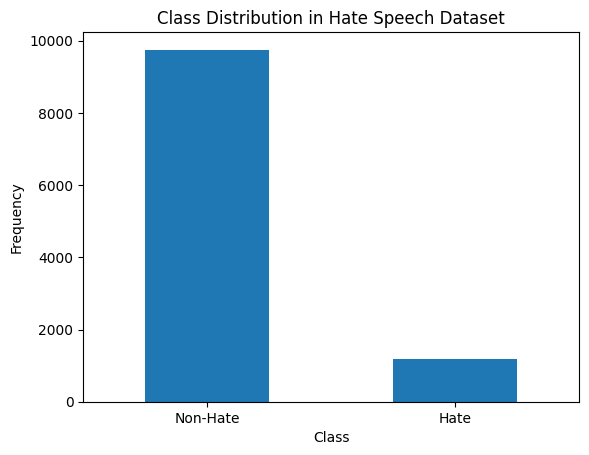

In [ ]:
import pandas as pd

# Convert the 'label' list into a Pandas Series
labels = pd.Series(dataset['train']['label'])

# Check the class distribution
print(labels.value_counts())

# Plot the class distribution
labels.value_counts().plot(kind='bar')
plt.title('Class Distribution in Hate Speech Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Non-Hate', 'Hate'], rotation=0)
plt.show()
